In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import datasets
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import h5py
%matplotlib inline

In [66]:
from PIL import Image

In [67]:
data_dir = '/content/drive/MyDrive/Miniproject/chest_xray/Dataset'

In [68]:
import pathlib
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*/*')))
print(image_count)

5866


In [69]:
# img = cv2.imread('/content/drive/MyDrive/Miniproject/chest_xray/Dataset/train/NORMAL/IM-0115-0001.jpeg')
# img.shape

In [70]:
# filepath = '/content/drive/MyDrive/Miniproject/chest_xray/Dataset/train/NORMAL/IM-0115-0001.jpeg'
# img = tf.io.read_file(filepath)
# img = tf.io.decode_jpeg(img, channels=1)
# print(img.shape)
# #print(tf.image.resize(img, [img_height, img_width]))


In [71]:
# Reading both normal and pneumonia files into a single object
train_ds_list = tf.data.Dataset.list_files(str(data_dir) +'/train/*/*', shuffle=True, seed = 0)
val_ds_list = tf.data.Dataset.list_files(str(data_dir) + '/val/*/*', shuffle= True, seed = 0)
test_ds_list = tf.data.Dataset.list_files(str(data_dir) + '/test/*/*', shuffle= True, seed = 0)

In [72]:
class_names = np.array(sorted(list(set([item.name for item in data_dir.glob('*/*') if item.name != "LICENSE.txt"]))))
print(class_names)

['NORMAL' 'PNEUMONIA']


In [73]:
img_height = 256
img_width = 256
batch_size = 32

In [74]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  #return tf.argmax(one_hot)
  return one_hot

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=1)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  #label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

# def label_path(file_path):
#   label = get_label(file_path)
#   return label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_list.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds_list.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds_list.map(process_path, num_parallel_calls=AUTOTUNE)

# train_class = train_ds_list.map(label_path, num_parallel_calls=AUTOTUNE)
# val_class = val_ds_list.map(label_path, num_parallel_calls=AUTOTUNE)
# test_class = test_ds_list.map(label_path, num_parallel_calls=AUTOTUNE)

In [75]:
rNr = tf.keras.Sequential([layers.Rescaling(1./255)]) #Rescaling
                           

In [76]:
def configure_for_performance(ds):
  ds = ds.batch(batch_size)
  ds = ds.map(lambda x : (rNr(x), rNr(x)), num_parallel_calls=AUTOTUNE)  
  ds = ds.cache()
  #ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

### Model Training

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization
from keras.models import Model

In [ ]:
input_img = Input(shape=(img_height,img_width,1), name="m1_encoder_input")
x = Conv2D(256, (3, 3), (2, 2), activation='relu', padding ='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), (2, 2), activation='relu', padding ='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), (2, 2), activation='relu', padding ='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Flatten()(x)
encoded = Dense(128, activation= 'relu')(x)

m1_encoder = Model(input_img, encoded, name="encoder_m1")

m1_encoder.summary()

Model: "encoder_m1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_encoder_input (InputLaye  [(None, 256, 256, 1)]    0         
 r)                                                              
                                                                 
 conv2d_29 (Conv2D)          (None, 128, 128, 256)     2560      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 256)      0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 64, 64, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 128)       295040    
                                                        

In [ ]:
input_latent = Input(shape=(128), name="m1_decoder_input")
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(input_latent)
x = Reshape((32,32,1))(x)

x = Conv2D(64, (3, 3), activation='relu', padding ='same')(x)
x = UpSampling2D((2,2))(x)

x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding ='same')(x)
x = UpSampling2D((2,2))(x)

x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding ='same')(x)
x = UpSampling2D((2,2))(x)

x = BatchNormalization()(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding ='same')(x)


m1_decoder = Model(input_latent, decoded, name="decoder_m1")

m1_decoder.summary()

Model: "decoder_m1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_decoder_input (InputLaye  [(None, 128)]            0         
 r)                                                              
                                                                 
 dense_9 (Dense)             (None, 1024)              132096    
                                                                 
 reshape_5 (Reshape)         (None, 32, 32, 1)         0         
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 up_sampling2d_15 (UpSamplin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Batc  (None, 64, 64, 64)       2

In [ ]:
# Autoencoder
ae_input = Input(shape=(img_height,img_width,1), name="m1_input")
ae_encoder_output = m1_encoder(ae_input)
ae_decoder_output = m1_decoder(ae_encoder_output)
m1 = tf.keras.models.Model(ae_input, ae_decoder_output, name="m1_output")
m1.summary()


Model: "m1_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_input (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 encoder_m1 (Functional)     (None, 128)               504384    
                                                                 
 decoder_m1 (Functional)     (None, 256, 256, 1)       505857    
                                                                 
Total params: 1,010,241
Trainable params: 1,008,449
Non-trainable params: 1,792
_________________________________________________________________


In [ ]:
# CUSTOM_loss
def MSSSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, 1.0))

#def a custom IoU

def customIoU(y_true, y_pred):
    nonzero_off = 1e-5
    y_true_f = tf.keras.backend.flatten(y_true[:,:,:,0])
    y_pred_f = tf.keras.backend.flatten(y_pred[:,:,:,0])
    #Compute intersection score in flattened vectors by dot mul
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f*y_true_f) + tf.keras.backend.sum(y_pred_f*y_pred_f) - intersection 
    iou = intersection/(union + nonzero_off)
    return iou

# AE Compilation
m1.compile(loss=MSSSIMLoss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[customIoU, tf.keras.metrics.KLDivergence(),tf.keras.metrics.MeanSquaredError()]) #learning_rate=0.0005 , metrics = [MSSSIMLoss, 'accuracy']

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

wtpath="/content/drive/MyDrive/Miniproject/chest_xray/CNN/weights/weights_best_fast.hdf5"
checkpoint = ModelCheckpoint(wtpath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=10,mode='min')
callbacks_list = [checkpoint,es]

In [ ]:
#### IoU val ####
from keras.models import load_model
m1test = load_model("/content/drive/MyDrive/Miniproject/chest_xray/CNN2/weights/weights_best_fast.hdf5", compile=False)
m1test.compile(metrics=[customIoU])  #NO loss metric given to compile
m1test.evaluate(test_ds)

In [ ]:
# Training AE
hist = m1.fit(train_ds, 
       epochs=50, 
       batch_size=batch_size, 
       #shuffle=True, 
       validation_data = val_ds,
       callbacks=callbacks_list)

Epoch 1/50
164/164 [==============================] - ETA: 0s - loss: 0.4980 - customIoU: 0.3088 - kullback_leibler_divergence: 2.0811 - mean_squared_error: 1.1753
Epoch 1: val_loss improved from inf to 0.64344, saving model to /content/drive/MyDrive/Miniproject/chest_xray/CNN/weights/weights_best_fast.hdf5
164/164 [==============================] - 141s 835ms/step - loss: 0.4980 - customIoU: 0.3088 - kullback_leibler_divergence: 2.0811 - mean_squared_error: 1.1753 - val_loss: 0.6434 - val_customIoU: 0.2619 - val_kullback_leibler_divergence: 0.3317 - val_mean_squared_error: 0.0782
Epoch 2/50
164/164 [==============================] - ETA: 0s - loss: 0.2973 - customIoU: 0.3672 - kullback_leibler_divergence: 0.4131 - mean_squared_error: 0.0270
Epoch 2: val_loss improved from 0.64344 to 0.53390, saving model to /content/drive/MyDrive/Miniproject/chest_xray/CNN/weights/weights_best_fast.hdf5
164/164 [==============================] - 134s 816ms/step - loss: 0.2973 - customIoU: 0.3672 - kul

In [ ]:
m1.save('/content/drive/MyDrive/Miniproject/chest_xray/CNN/weights/model_last_fast.hdf5')  # creates a HDF5 file 'my_model.h5'

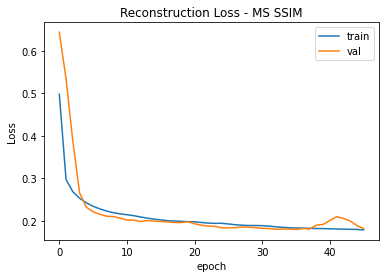

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Reconstruction Loss - MS SSIM')
plt.ylabel('Loss')
plt.autoscale()
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN/msssim.jpg')
plt.show()

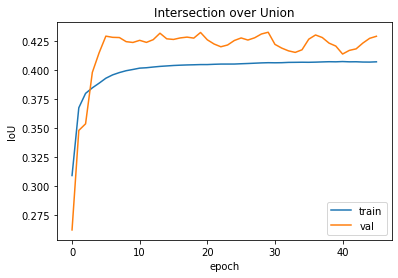

In [ ]:
plt.plot(hist.history['customIoU'])
plt.plot(hist.history['val_customIoU'])
plt.title('Intersection over Union')
plt.ylabel('IoU')
#plt.ylim(top=0.02,bottom = 0.001)
plt.autoscale()
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
#plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN/iou.jpg')
plt.show()

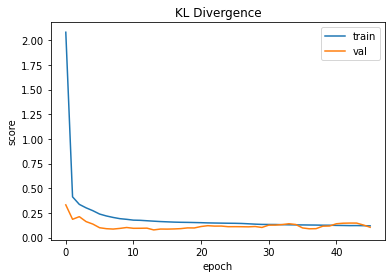

In [ ]:
plt.plot(hist.history['kullback_leibler_divergence'])
plt.plot(hist.history['val_kullback_leibler_divergence'])
plt.title('KL Divergence')
plt.ylabel('score')
plt.autoscale()
#plt.ylim(top=0.02,bottom = 0.001)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN/kld.jpg')
plt.show()

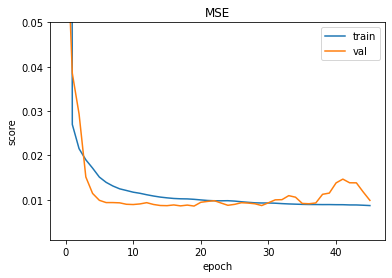

In [ ]:
plt.plot(hist.history['mean_squared_error'])
plt.plot(hist.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('score')
plt.autoscale()
plt.ylim(top=0.05,bottom = 0.001)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN/mse.jpg')
plt.show()

In [ ]:
m1.evaluate(test_ds)

20/20 [==============================] - 75s 4s/step - loss: 0.1973 - customIoU: 0.4044 - kullback_leibler_divergence: 0.1385 - mean_squared_error: 0.0100


[0.19730983674526215,
 0.4044497013092041,
 0.13847525417804718,
 0.010033362545073032]

# Load model

In [15]:
from keras.models import load_model
m1 = load_model("/content/drive/MyDrive/Miniproject/chest_xray/CNN/weights/weights_best_fast.hdf5", compile=False)

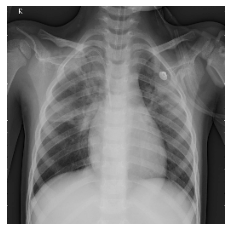

In [21]:
for batch in test_ds.take(1):
    #print(image[0].shape)
    image = batch[0][0]
    plt.imshow(image.numpy().reshape(256,256),'gray')
    plt.axis('off')
    #cv2.imwrite('hello.jpg',image.numpy().reshape(256,256)*255)

In [22]:
cv2.imwrite('/content/drive/MyDrive/Miniproject/chest_xray/CNN/True.png',image.numpy().reshape(256,256)*255)

True

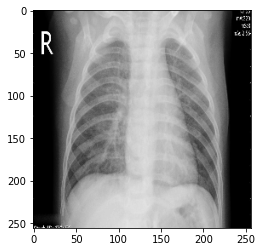

In [94]:
for batchs in test_ds.take(6):
    #print(image[0].shape)
    batch = batchs[0]
    plt.imshow(batch[0].numpy().reshape(256,256)*255,'gray')

In [88]:
pred_ds = m1.predict(test_ds)
#plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN/Reconstruction.jpg')

KeyboardInterrupt: ignored

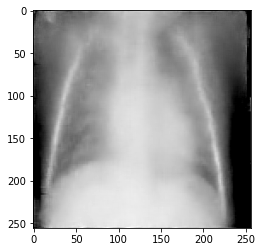

In [89]:
rec = pred_ds[0]
plt.imshow(rec.reshape(256,256),'gray')

In [ ]:
cv2.imwrite('/content/drive/MyDrive/Miniproject/chest_xray/CNN/ReconstructionCNN.png',rec.reshape(256,256)*)

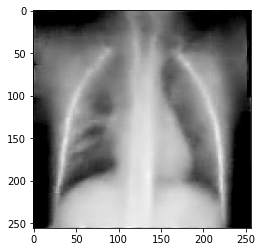

In [ ]:
from keras.models import load_model
mbest = load_model("/content/drive/MyDrive/Miniproject/chest_xray/CNN/weights/weights_best_fast.hdf5", compile=False)

pred_ds = mbest.predict(test_ds)
rec = pred_ds[0]
plt.imshow(rec.reshape(256,256),'gray')
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN/Reconstruction_1.jpg')

In [ ]:
diff = image - rec
np.mean(np.square(diff.numpy()))

0.049980387

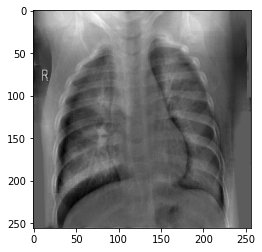

In [ ]:
plt.imshow(diff.numpy().reshape(256,256),'gray')
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN/Delta.jpg')

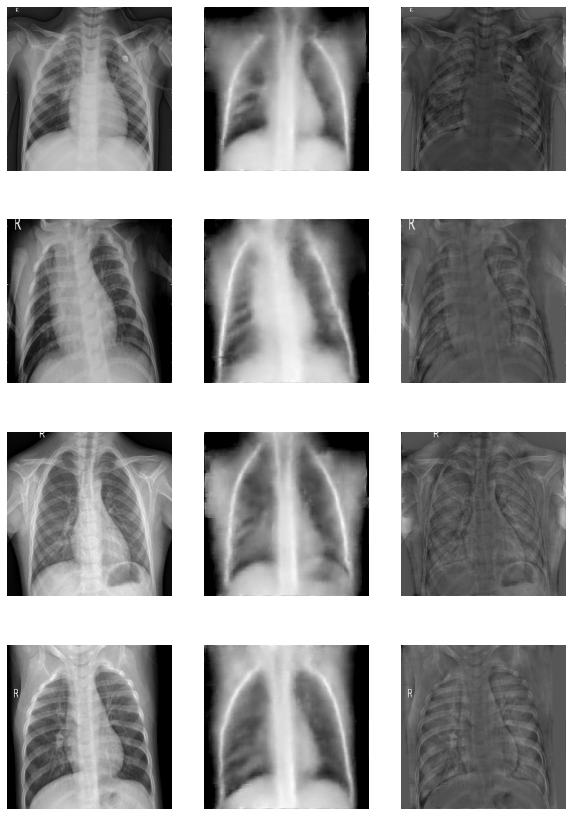

In [ ]:
plt.figure(figsize=(10,15)) 
num_images_to_show = 4
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*3 + 1
    #rand_ind = np.random.randint(low=0, high=x_train.shape[0])
    plt.subplot(num_images_to_show, 3, plot_ind)
    for batch in test_ds.take(1):
        image = batch[0][im_ind]
        plt.imshow(image.numpy().reshape(256,256),'gray')
        plt.axis('off')
    rec = pred_ds[im_ind]
    plt.subplot(num_images_to_show, 3, plot_ind+1)
    plt.imshow(rec.reshape(256,256),'gray')
    plt.axis('off')
    plt.subplot(num_images_to_show, 3, plot_ind+2)
    diff = image - rec
    plt.imshow(diff.numpy().reshape(256,256),'gray')
    plt.axis('off')
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.5, 
#                     top=0.2, 
#                     wspace=0.5, 
#                     hspace=0.5)
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN/summary_1.jpg')

In [ ]:
mbest.compile(loss=MSSSIMLoss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[customIoU, tf.keras.metrics.KLDivergence(),tf.keras.metrics.MeanSquaredError()]) #learning_rate=0.0005 , metrics = [MSSSIMLoss, 'accuracy']
mbest.evaluate(test_ds)

20/20 [==============================] - 5s 172ms/step - loss: 0.1959 - customIoU: 0.4004 - kullback_leibler_divergence: 0.1324 - mean_squared_error: 0.0097


[0.19594763219356537,
 0.4004334509372711,
 0.13235071301460266,
 0.009683399461209774]

In [ ]:
predictions = mbest.predict(test_ds)

In [ ]:
predictions.shape

(624, 256, 256, 1)

In [ ]:
for batch in test_ds.take(1):
    imgb = batch[0]
imgb.shape

TensorShape([32, 256, 256, 1])

In [ ]:
delta = []
for im_ind in range(624):
    #plot_ind = im_ind*3 + 1
    #rand_ind = np.random.randint(low=0, high=x_train.shape[0])
    #plt.subplot(num_images_to_show, 3, plot_ind)
    for batch in test_ds.take(im_ind // 32 + 1):
        imgb = batch[0]
    image = imgb[im_ind % 32]
    rec = pred_ds[im_ind]
    diff = image - rec
    delta.append(diff)


In [ ]:
delta_arr = np.array(delta)

In [ ]:
np.savez('/content/drive/MyDrive/Miniproject/chest_xray/CNN/delta.npz',delta_arr)

# Compressing Delta

In [79]:
import numpy as np
delta_arr = np.load('/content/drive/MyDrive/Miniproject/chest_xray/CNN/delta.npz')

In [80]:
list(delta_arr.keys())

['arr_0']

In [81]:
delta = delta_arr['arr_0']

In [82]:
img1 = delta[0]

In [83]:
img1 = img1.reshape(256,256)

In [84]:
import matplotlib.pyplot as plt


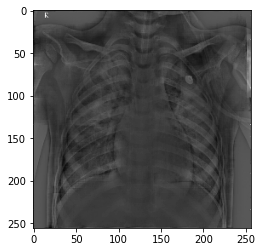

In [85]:
plt.imshow(img1,'gray')

In [ ]:
np.mean(img1)

0.016281877

In [ ]:
np.max(img1)

0.9977635

In [ ]:
np.min(img1)

-0.31455818

In [ ]:
valrange = np.max(img1) - np.min(img1)

In [ ]:
img1_sc = (img1 - np.min(img1))/valrange*255

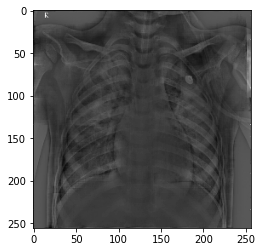

In [ ]:
plt.imshow(img1_sc,'gray')

In [ ]:
img1_8 = img1_sc.astype('uint8')

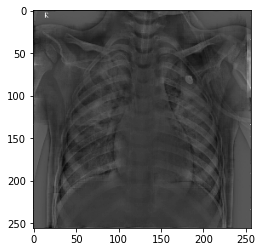

In [ ]:
plt.imshow(img1_8,'gray')

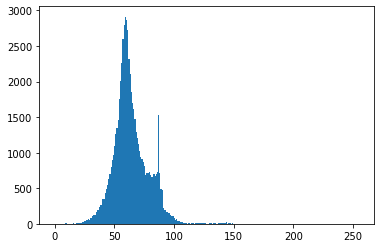

In [ ]:
plt.hist(img1_8.flatten(),256);

### PYAE

In [ ]:
%%writefile pyae.py

from decimal import Decimal

class ArithmeticEncoding:
    """
    ArithmeticEncoding is a class for building the arithmetic encoding.
    """

    def __init__(self, frequency_table, save_stages=False):
        """
        frequency_table: Frequency table as a dictionary where key is the symbol and value is the frequency.
        save_stages: If True, then the intervals of each stage are saved in a list. Note that setting save_stages=True may cause memory overflow if the message is large
        """
        
        self.save_stages = save_stages
        if(save_stages == True):
            print("WARNING: Setting save_stages=True may cause memory overflow if the message is large.")

        self.probability_table = self.get_probability_table(frequency_table)

    def get_probability_table(self, frequency_table):
        """
        Calculates the probability table out of the frequency table.

        frequency_table: A table of the term frequencies.

        Returns the probability table.
        """
        total_frequency = sum(list(frequency_table.values()))

        probability_table = {}
        for key, value in frequency_table.items():
            probability_table[key] = value/total_frequency

        return probability_table

    def get_encoded_value(self, last_stage_probs):
        """
        After encoding the entire message, this method returns the single value that represents the entire message.

        last_stage_probs: A list of the probabilities in the last stage.
        
        Returns the minimum and maximum probabilites in the last stage in addition to the value encoding the message.
        """
        last_stage_probs = list(last_stage_probs.values())
        last_stage_values = []
        for sublist in last_stage_probs:
            for element in sublist:
                last_stage_values.append(element)

        last_stage_min = min(last_stage_values)
        last_stage_max = max(last_stage_values)
        encoded_value = (last_stage_min + last_stage_max)/2

        return last_stage_min, last_stage_max, encoded_value

    def process_stage(self, probability_table, stage_min, stage_max):
        """
        Processing a stage in the encoding/decoding process.

        probability_table: The probability table.
        stage_min: The minumim probability of the current stage.
        stage_max: The maximum probability of the current stage.
        
        Returns the probabilities in the stage.
        """

        stage_probs = {}
        stage_domain = stage_max - stage_min
        for term_idx in range(len(probability_table.items())):
            term = list(probability_table.keys())[term_idx]
            term_prob = Decimal(probability_table[term])
            cum_prob = term_prob * stage_domain + stage_min
            stage_probs[term] = [stage_min, cum_prob]
            stage_min = cum_prob
        return stage_probs

    def encode(self, msg, probability_table):
        """
        Encodes a message using arithmetic encoding.

        msg: The message to be encoded.
        probability_table: The probability table.

        Returns the encoder, the floating-point value representing the encoded message, and the maximum and minimum values of the interval in which the floating-point value falls.
        """
        
        msg = list(msg)

        encoder = []

        stage_min = Decimal(0.0)
        stage_max = Decimal(1.0)

        for msg_term_idx in range(len(msg)):
            stage_probs = self.process_stage(probability_table, stage_min, stage_max)

            msg_term = msg[msg_term_idx]
            stage_min = stage_probs[msg_term][0]
            stage_max = stage_probs[msg_term][1]

            if self.save_stages:
                encoder.append(stage_probs)

        last_stage_probs = self.process_stage(probability_table, stage_min, stage_max)
        
        if self.save_stages:
            encoder.append(last_stage_probs)

        interval_min_value, interval_max_value, encoded_msg = self.get_encoded_value(last_stage_probs)

        return encoded_msg, encoder, interval_min_value, interval_max_value

    def process_stage_binary(self, float_interval_min, float_interval_max, stage_min_bin, stage_max_bin):
        """
        Processing a stage in the encoding/decoding process.

        float_interval_min: The minimum floating-point value in the interval in which the floating-point value that encodes the message is located.
        float_interval_max: The maximum floating-point value in the interval in which the floating-point value that encodes the message is located.
        stage_min_bin: The minimum binary number in the current stage.
        stage_max_bin: The maximum binary number in the current stage.

        Returns the probabilities of the terms in this stage. There are only 2 terms.
        """

        stage_mid_bin = stage_min_bin + "1"
        stage_min_bin = stage_min_bin + "0"

        stage_probs = {}
        stage_probs[0] = [stage_min_bin, stage_mid_bin]
        stage_probs[1] = [stage_mid_bin, stage_max_bin]

        return stage_probs

    def encode_binary(self, float_interval_min, float_interval_max):
        """
        Calculates the binary code that represents the floating-point value that encodes the message.

        float_interval_min: The minimum floating-point value in the interval in which the floating-point value that encodes the message is located.
        float_interval_max: The maximum floating-point value in the interval in which the floating-point value that encodes the message is located.

        Returns the binary code representing the encoded message.
        """

        binary_encoder = []
        binary_code = None

        stage_min_bin = "0.0"
        stage_max_bin = "1.0"

        stage_probs = {}
        stage_probs[0] = [stage_min_bin, "0.1"]
        stage_probs[1] = ["0.1", stage_max_bin]
        
        while True:
            if float_interval_max < bin2float(stage_probs[0][1]):
                stage_min_bin = stage_probs[0][0]
                stage_max_bin = stage_probs[0][1]
            else:
                stage_min_bin = stage_probs[1][0]
                stage_max_bin = stage_probs[1][1]

            if self.save_stages:
                binary_encoder.append(stage_probs)

            stage_probs = self.process_stage_binary(float_interval_min,
                                                    float_interval_max,
                                                    stage_min_bin,
                                                    stage_max_bin)

            # print(stage_probs[0][0], bin2float(stage_probs[0][0]))
            # print(stage_probs[0][1], bin2float(stage_probs[0][1]))
            if (bin2float(stage_probs[0][0]) >= float_interval_min) and (bin2float(stage_probs[0][1]) < float_interval_max):
                # The binary code is found.
                # print(stage_probs[0][0], bin2float(stage_probs[0][0]))
                # print(stage_probs[0][1], bin2float(stage_probs[0][1]))
                # print("The binary code is : ", stage_probs[0][0])
                binary_code = stage_probs[0][0]
                break
            elif (bin2float(stage_probs[1][0]) >= float_interval_min) and (bin2float(stage_probs[1][1]) < float_interval_max):
                # The binary code is found.
                # print(stage_probs[1][0], bin2float(stage_probs[1][0]))
                # print(stage_probs[1][1], bin2float(stage_probs[1][1]))
                # print("The binary code is : ", stage_probs[1][0])
                binary_code = stage_probs[1][0]
                break

        if self.save_stages:
            binary_encoder.append(stage_probs)

        return binary_code, binary_encoder

    def decode(self, encoded_msg, msg_length, probability_table):
        """
        Decodes a message from a floating-point number.
        
        encoded_msg: The floating-point value that encodes the message.
        msg_length: Length of the message.
        probability_table: The probability table.

        Returns the decoded message.
        """

        decoder = []

        decoded_msg = []

        stage_min = Decimal(0.0)
        stage_max = Decimal(1.0)

        for idx in range(msg_length):
            stage_probs = self.process_stage(probability_table, stage_min, stage_max)

            for msg_term, value in stage_probs.items():
                if encoded_msg >= value[0] and encoded_msg <= value[1]:
                    break

            decoded_msg.append(msg_term)

            stage_min = stage_probs[msg_term][0]
            stage_max = stage_probs[msg_term][1]

            if self.save_stages:
                decoder.append(stage_probs)

        if self.save_stages:
            last_stage_probs = self.process_stage(probability_table, stage_min, stage_max)
            decoder.append(last_stage_probs)

        return decoded_msg, decoder

def float2bin(float_num, num_bits=None):
    """
    Converts a floating-point number into binary.

    float_num: The floating-point number. 
    num_bits: The number of bits expected in the result. If None, then the number of bits depends on the number.

    Returns the binary representation of the number.
    """

    float_num = str(float_num)
    if float_num.find(".") == -1:
        # No decimals in the floating-point number.
        integers = float_num
        decimals = ""
    else:
        integers, decimals = float_num.split(".")
    decimals = "0." + decimals
    decimals = Decimal(decimals)
    integers = int(integers)

    result = ""
    num_used_bits = 0
    while True:
        mul = decimals * 2
        int_part = int(mul)
        result = result + str(int_part)
        num_used_bits = num_used_bits + 1

        decimals = mul - int(mul)
        if type(num_bits) is type(None):
            if decimals == 0:
                break
        elif num_used_bits >= num_bits:
            break
    if type(num_bits) is type(None):
        pass
    elif len(result) < num_bits:
        num_remaining_bits = num_bits - len(result)
        result = result + "0"*num_remaining_bits

    integers_bin = bin(integers)[2:]
    result = str(integers_bin) + "." + str(result)
    return result

def bin2float(bin_num):
    """
    Converts a binary number to a floating-point number.

    bin_num: The binary number as a string.

    Returns the floating-point representation.
    """

    if bin_num.find(".") == -1:
        # No decimals in the binary number.
        integers = bin_num
        decimals = ""
    else:
        integers, decimals = bin_num.split(".")
    result = Decimal(0.0)

    # Working with integers.
    for idx, bit in enumerate(integers):
        if bit == "0":
            continue
        mul = 2**idx
        result = result + Decimal(mul)

    # Working with decimals.
    for idx, bit in enumerate(decimals):
        if bit == "0":
            continue
        mul = Decimal(1.0)/Decimal((2**(idx+1)))
        result = result + mul
    return result

Overwriting pyae.py


# Arithmetic Encoding

In [ ]:
src = img1_8.flatten()

In [ ]:
src_txt = ""
for pix in src:
    src_txt += str(pix)

In [ ]:
freq, bin = np.histogram(src,256)

In [ ]:
#bin = bin.astype('uint8')
freq.shape

(256,)

In [ ]:
freq_table = {}
for i in range(10):
    freq_table[str(i)] = 0
for i in src_txt:
    freq_table[i] += 1

In [ ]:
freq_table

{'0': 7190,
 '1': 7256,
 '2': 6551,
 '3': 7872,
 '4': 12328,
 '5': 25786,
 '6': 25575,
 '7': 16088,
 '8': 14446,
 '9': 8688}

In [ ]:
import pyae

In [ ]:
len(src_txt)

131780

In [ ]:
from decimal import getcontext

getcontext().prec = 125000

In [ ]:
AE = pyae.ArithmeticEncoding(frequency_table=freq_table,
                            save_stages=False)

In [ ]:
encoded_msg, encoder , interval_min_value, interval_max_value = AE.encode(msg=src_txt, 
                                                                          probability_table=AE.probability_table)
print("Encoded Message: {msg}".format(msg=encoded_msg))

Encoded Message: 0.944536831990196470089977907883883754746382150781902636098014437307149726919485337559160288508288935854896597101688997704770338256364389279176082772672751172791370007952760457551970869036100173177217604551860541098316762934920048696683602865248186092397307611878427026573836580134184498778357651156360061304299437836340532479792928950032003538571723417356608687071985687147251723270949173869502997606651292076958319377548315943628296891417467025702507316229093421980506281553593989982122204024567975992198190611037322331374172480339914614800810804093413797920321624165096112241257230734866623099150633048177215131708263088534163099074867749876692340863733917294949543855904964901252715978888701392101914554112483513466508617699268447074355906143959493270127614779639296926042073866098444153528537860650979324787390504330746868548927439540479274568667304148151579737974357453015987216102233775805008437988136207964260059280129558064342280250483590034855330839228392439164150928081956

In [ ]:
decoded_msg, decoder = AE.decode(encoded_msg=encoded_msg, 
                                 msg_length=len(src_txt),
                                 probability_table=AE.probability_table)
decoded_msg = "".join(decoded_msg)
print("Decoded Message: {msg}".format(msg=decoded_msg))
print("Message Decoded Successfully? {result}".format(result=src_txt == decoded_msg))

Decoded Message: 92978999898866869878787888889898989898989898989887079869090899090909090909090909090909090838361637383909090909090909090909090909089898989898888878787878686858483828079777465928887848078696862615655555354555860615760727074898482858591104857679687062535655585961566164614748616373797276818389969794981009999979597939595887979878889921009696961031081101161491291161071029999981028985767871707477788081818383848585858687878788888888888989898990909090878379829089909090908785816959556769696980736564546259658890909090908989898888159198100101908686878782878888898989647272737482777869848890908990909090909090909090909090909090838790909090909090909090909090909090898988888988888787838280757369676765605944486564677067686166615954504743424148484643374444454866677263686362575655515354544546454242434551313031324855495160667375717177787473727371757578727066716971737575726772686763888372676863706669404756697058596670737580838384858585868787878888888888898983857980808082878988909090909090898

## Huffmann

In [ ]:
# A Huffman Tree Node
class Node:
    def __init__(self, prob, symbol, left=None, right=None):
        # probability of symbol
        self.prob = prob

        # symbol 
        self.symbol = symbol

        # left node
        self.left = left

        # right node
        self.right = right

        # tree direction (0/1)
        self.code = ''

""" A helper function to print the codes of symbols by traveling Huffman Tree"""
codes = dict()

def Calculate_Codes(node, val=''):
    # huffman code for current node
    newVal = val + str(node.code)

    if(node.left):
        Calculate_Codes(node.left, newVal)
    if(node.right):
        Calculate_Codes(node.right, newVal)

    if(not node.left and not node.right):
        codes[node.symbol] = newVal
         
    return codes        

""" A helper function to calculate the probabilities of symbols in given data"""
def Calculate_Probability(data):
    symbols = dict()
    for element in data:
        if symbols.get(element) == None:
            symbols[element] = 1
        else: 
            symbols[element] += 1     
    return symbols

""" A helper function to obtain the encoded output"""
def Output_Encoded(data, coding):
    encoding_output = []
    for c in data:
      #  print(coding[c], end = '')
        encoding_output.append(coding[c])
        
    string = ''.join([str(item) for item in encoding_output])    
    return string
        
""" A helper function to calculate the space difference between compressed and non compressed data"""    
def Total_Gain(data, coding):
    before_compression = len(data) * 8 # total bit space to stor the data before compression
    after_compression = 0
    symbols = coding.keys()
    for symbol in symbols:
        count = data.count(symbol)
        after_compression += count * len(coding[symbol]) #calculate how many bit is required for that symbol in total
    print("Space usage before compression (in bits):", before_compression)    
    print("Space usage after compression (in bits):",  after_compression)           

def Huffman_Encoding(data):
    symbol_with_probs = Calculate_Probability(data)
    symbols = symbol_with_probs.keys()
    probabilities = symbol_with_probs.values()
    print("symbols: ", symbols)
    print("probabilities: ", probabilities)
    
    nodes = []
    
    # converting symbols and probabilities into huffman tree nodes
    for symbol in symbols:
        nodes.append(Node(symbol_with_probs.get(symbol), symbol))
    
    while len(nodes) > 1:
        # sort all the nodes in ascending order based on their probability
        nodes = sorted(nodes, key=lambda x: x.prob)
        # for node in nodes:  
        #      print(node.symbol, node.prob)
    
        # pick 2 smallest nodes
        right = nodes[0]
        left = nodes[1]
    
        left.code = 0
        right.code = 1
    
        # combine the 2 smallest nodes to create new node
        newNode = Node(left.prob+right.prob, left.symbol+right.symbol, left, right)
    
        nodes.remove(left)
        nodes.remove(right)
        nodes.append(newNode)
            
    huffman_encoding = Calculate_Codes(nodes[0])
    print("symbols with codes", huffman_encoding)
    Total_Gain(data, huffman_encoding)
    encoded_output = Output_Encoded(data,huffman_encoding)
    return encoded_output, nodes[0]  
    
 
def Huffman_Decoding(encoded_data, huffman_tree):
    tree_head = huffman_tree
    decoded_output = []
    for x in encoded_data:
        if x == '1':
            huffman_tree = huffman_tree.right   
        elif x == '0':
            huffman_tree = huffman_tree.left
        try:
            if huffman_tree.left.symbol == None and huffman_tree.right.symbol == None:
                pass
        except AttributeError:
            decoded_output.append(huffman_tree.symbol)
            huffman_tree = tree_head
        
    string = ''.join([str(item) for item in decoded_output])
    return string        


# """ First Test """
# data = "AAAAAAABCCCCCCDDEEEEE"
# print(data)
# encoding, tree = Huffman_Encoding(data)
# print("Encoded output", encoding)
# print("Decoded Output", Huffman_Decoding(encoding,tree))

In [ ]:
print("Encoding:")
Huffman_Encoding(src_txt)

Encoding:
symbols:  dict_keys(['9', '2', '7', '8', '6', '0', '3', '1', '5', '4'])
probabilities:  dict_values([8688, 6551, 16088, 14446, 25575, 7190, 7872, 7256, 25786, 12328])
symbols with codes {'6': '000', '4': '0010', '9': '0011', '7': '010', '3': '0110', '1': '0111', '8': '100', '0': '1010', '2': '1011', '5': '11'}
Space usage before compression (in bits): 1054240
Space usage after compression (in bits): 419439


('00111011001101010000110011001110000111001000000001000000011100010100010100010100100100100100001110000111000011100001110000111000011100001110000111000011100001110010001010100100011100000001110100011101010000110011101000111010001110100011101000111010001110100011101000111010001110100011101000111010001110100011101000111010100011010001100000111000011001001101000110001110100011101000111010001110100011101000111010001110100011101000111010001110100011101000111010001110100011101010000111000011100001110000111000011100100100100100010100010100010100010100000100000100111000010100011010010111001010010001101001001000100001100111011100100100010100001010010100101000000011000100000101100001111100011111111110110110010111111100000101000001111101000010100101011010101001000101000011100001010010111001110011001101110111101000101001101000001000110001000101010000101111011011000111111100110011000011111000000011100000100000111001001000101000000111000011001001100100011010101101000010001111000110100001100110000011

# Lossless DCT

In [ ]:
import numpy as np
np.save('/content/drive/MyDrive/Miniproject/chest_xray/CNN/onechest.npy',img1_8)

In [ ]:
!git clone https://github.com/ojaashampiholi/DCT_Analysis.git

Cloning into 'DCT_Analysis'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 94 (delta 36), reused 51 (delta 10), pack-reused 0
Unpacking objects: 100% (94/94), done.


In [ ]:
!python3 /content/drive/MyDrive/Miniproject/chest_xray/DCT_Analysis/imageCompression.py "/content/drive/MyDrive/Miniproject/chest_xray/CNN/onechest.npy" 256 256

------------------------------------------------------------
Processing with Input Image
------------------------------------------------------------
Input Image Size (256, 256)
------------------------------------------------------------
Shape of the Resized Image is (256, 256)
------------------------------------------------------------
Shape of Processed Grayscale Image is (5, 5, 961)
Compression Rate Achieved is 0.6334075928
------------------------------------------------------------
Saving the Processed Image to npy file
------------------------------------------------------------
Processing Successful


In [ ]:
# Test processed img
pr = np.load('processedGray.npy')
pr.shape

(5, 5, 961)

In [ ]:
# Delta matrix to jpeg
import cv2
cv2.imwrite('delta.jpg',img1_8)

True

## Reload models and try!

In [ ]:
from keras.models import load_model
dummy = load_model("/content/drive/MyDrive/Miniproject/chest_xray/CNN/weights/weights_best_fast.hdf5", compile=False)

from keras.models import Model
testen = Model(inputs = dummy.layers[1].input, outputs = dummy.layers[1].output)  
testde = Model(inputs = dummy.layers[2].input, outputs = dummy.layers[2].output)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


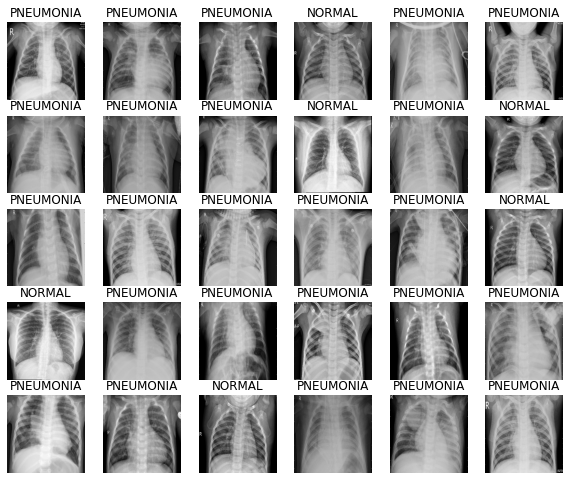

In [ ]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(30):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().reshape(img_height,img_width),'gray')
        #plt.title(class_names[[tf.argmax(labels[i])]])
        plt.axis("off")

In [ ]:
batch[0][0]

<tf.Tensor: shape=(65536,), dtype=float32, numpy=
array([0.17245711, 0.19451594, 0.17938113, ..., 0.14117648, 0.1387255 ,
       0.13725491], dtype=float32)>

In [ ]:
diff = image - rec
np.mean(np.square(diff.numpy()))

0.004987583

In [ ]:
np.sqrt(0.00587*255*255)

19.537060935565513